# 1. Import Libraries

In [429]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

# 2. Load the Dataset

In [430]:
path = '/content/KNNAlgorithmDataset.csv'
dataset = pd.read_csv(path)
print("Dataset Loaded:\n", dataset.head())

Dataset Loaded:
          id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_

# 3. Preprocess the Dataset

See the number of missing values for each feature

In [431]:
print(dataset.isnull().sum())

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

Drop the column `id` besause it doesn't affect the classification and the column `Unnamed: 32` because it has too many missing values.

In [432]:
dataset = dataset.drop(columns=['id','Unnamed: 32'])

Function to preprocess the dataset and split it into train data and test data

In [433]:
def preprocess_dataset(dataset, target_columns):
    # Encode categorical variables
    le = LabelEncoder()
    for column in dataset.select_dtypes(include=['object']).columns:
        dataset[column] = le.fit_transform(dataset[column])

    # Split dataset
    X = dataset.drop(columns=target_columns)  # Features
    X = StandardScaler().fit_transform(X)
    y = dataset[target_columns].values.ravel() # Target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [434]:
X_train, X_test, y_train, y_test = preprocess_dataset(dataset, target_columns=['diagnosis'])
print("Data Preprocessing Completed.")

Data Preprocessing Completed.


# 4. Apply KNN using sklearn

In [435]:
def apply_library_knn(X_train, X_test, y_train, y_test, k=5):
    knn = KNeighborsClassifier(n_neighbors=k)  # Default k=5
    start_time = time.time()
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    end_time = time.time()

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    matrix = confusion_matrix(y_test, y_pred)

    print(f"\nLibrary KNN Execution Time: {end_time - start_time:.4f} seconds")
    print(f"\nAccuracy: {accuracy:.2f}")
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n")
    sns.heatmap(matrix, annot=True, cmap="Blues")

    return knn, accuracy, end_time - start_time

Applying KNN using sklearn...

Library KNN Execution Time: 0.0047 seconds

Accuracy: 0.95

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114


Confusion Matrix:



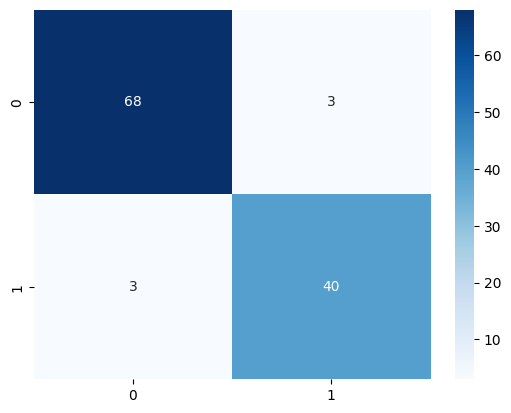

In [436]:
print("Applying KNN using sklearn...")
knn, accuracy, time_taken = apply_library_knn(X_train, X_test, y_train, y_test, k=5)

# 5. Apply Costum KNN with Parzen window method

Gaussian kernel function

In [437]:
def gaussian_kernel(distance, bandwidth):
    return np.exp(-0.5 * (distance / bandwidth) ** 2)

Custom KNN Classifier with Parzen Window

In [438]:
class CustomKNN:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict_single(self, x):
        # Calculate distances
        distances = np.linalg.norm(self.X_train - x.reshape((1,-1)), axis=1)

        # Sort indices by distance
        sorted_indices = np.argsort(distances)

        # Select k nearest neighbors
        k_nearest_indices = sorted_indices[:self.k]
        k_nearest_distances = distances[k_nearest_indices]
        k_nearest_labels = self.y_train[k_nearest_indices]

        # Apply Gaussian kernel for weights
        weights = np.zeros((self.k, len(np.unique(self.y_train))))
        bandwidth = np.sort(distances, axis=0)[self.k]
        weights[np.arange(self.k), k_nearest_labels] = 1 / np.sqrt(2 * np.pi) * gaussian_kernel(k_nearest_distances, bandwidth)

        # Aggregate weights per class
        class_weights = {}
        for label, weight in zip(k_nearest_labels, weights):
            class_weights[label] = class_weights.get(label, 0) + weight

        # Predict class with max weight
        predicted_class = np.argmax(np.sum(weights, axis=0)).astype(np.int32)

        return predicted_class

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            predictions.append(self.predict_single(x))

        return np.array(predictions)

Evaluate custom KNN

In [439]:
def evaluate_custom_knn(X_train, X_test, y_train, y_test, k=5):
    custom_knn = CustomKNN(k=k)
    custom_knn.fit(X_train, y_train)

    start_time = time.time()
    y_pred = custom_knn.predict(X_test)
    end_time = time.time()

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    matrix = confusion_matrix(y_test, y_pred)

    print(f"\nCustom KNN Execution Time: {end_time - start_time:.4f} seconds")
    print(f"\nAccuracy: {accuracy:.2f}")
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n")
    sns.heatmap(matrix, annot=True, cmap="Blues")

    return custom_knn, accuracy, end_time - start_time

Evaluating Custom KNN with Parzen Window...

Custom KNN Execution Time: 0.0283 seconds

Accuracy: 0.95

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114


Confusion Matrix:



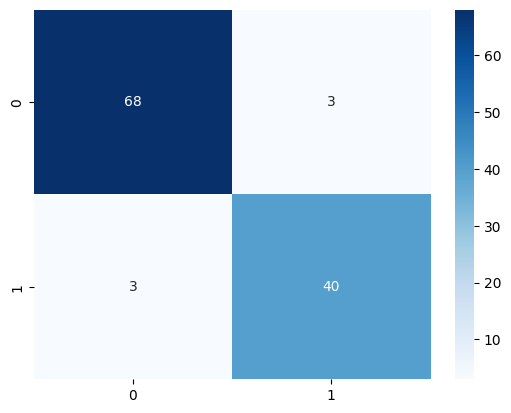

In [440]:
print("Evaluating Custom KNN with Parzen Window...")
custom_knn, accuracy, time_taken = evaluate_custom_knn(X_train, X_test, y_train, y_test, k=5)

# 6. LOO Cross-Validation

LOO Cross-Validation Function

In [441]:
def loo_cross_validation(X, y, k_values, knn_module_name):
    n_samples = len(X)
    best_k = None
    min_risk = float('inf')
    risks = []

    for k in k_values:
        total_errors = 0
        for i in range(n_samples):
            # Split data for LOO: 1 test sample, n-1 training samples
            X_train = np.delete(X, i, axis=0)
            y_train = np.delete(y, i, axis=0)
            X_test = X[i].reshape(1, -1)
            y_test = y[i]

            # Train KNN Module
            knn_module = None
            if knn_module_name == 'CustomKNN':
                knn_module = CustomKNN(k=k)
            elif knn_module_name == 'KNeighborsClassifier':
                knn_module = KNeighborsClassifier(n_neighbors=k)
            knn_module.fit(X_train, y_train)
            y_pred = knn_module.predict(X_test)[0]

            # Count errors
            if y_pred != y_test:
                total_errors += 1

        # Compute risk (error rate)
        risk = total_errors / n_samples
        risks.append(risk)

        # Update best parameters
        if risk < min_risk:
            min_risk = risk
            best_k = k

    return best_k, risks

Plot Empirical Risk

In [442]:
def plot_risk(risks, k_values):
    plt.plot(k_values, risks, 'b-o', markersize=6, markeredgecolor='k')
    plt.xlim(0, 30)
    plt.grid("on")
    plt.ylabel("Error rate")
    plt.xlabel("k neighbours")
    plt.title("Leave One Out Method")

In [443]:
X = dataset.drop(columns=['diagnosis'])  # Features
X = StandardScaler().fit_transform(X)
y = dataset['diagnosis'].values.ravel() # Target

# Define k and bandwidth ranges
k_values = list(range(1, 30))

Running LOO Cross-Validation for Reference KNN...
Best k: 5


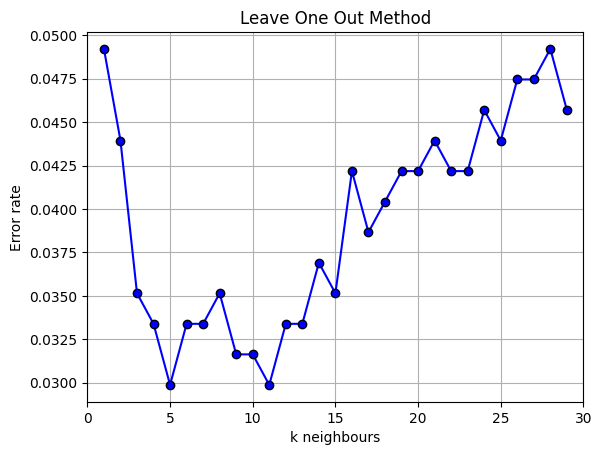

In [444]:
print("Running LOO Cross-Validation for Reference KNN...")
best_k_ref, risks_ref = loo_cross_validation(X, y, k_values, knn_module_name='KNeighborsClassifier')
print(f"Best k: {best_k_ref}")

# Plot empirical risk
plot_risk(risks_ref, k_values)

Running LOO Cross-Validation for Custom KNN...
Best k: 5


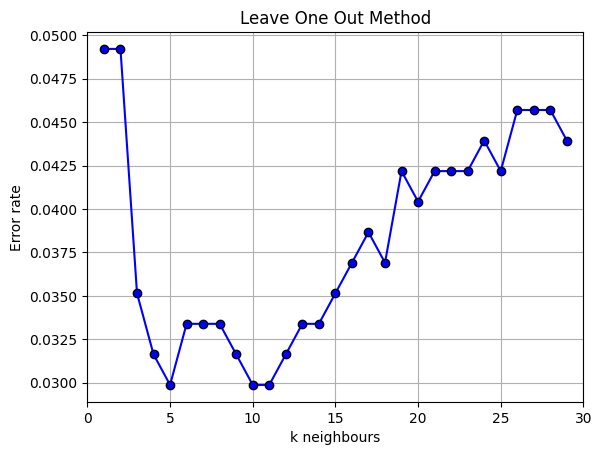

In [445]:
print("Running LOO Cross-Validation for Custom KNN...")
best_k_imp, risks_imp = loo_cross_validation(X, y, k_values, knn_module_name='CustomKNN')
print(f"Best k: {best_k_imp}")

# Plot empirical risk
plot_risk(risks_imp, k_values)

# 7. Checking performance for a random test value

In [446]:
index = random.randint(0, len(X_test))
x = X_test[index]

# init custom KNN
knn_imp = CustomKNN(k=9)
knn_imp.fit(X_train,y_train)

#init reference KNN
knn_ref = KNeighborsClassifier(n_neighbors=9)
knn_ref.fit(X_train,y_train)

# run custom KNN
start_imp = time.time()
pred_imp = knn_imp.predict_single(x)
end_imp = time.time()

e_imp = (end_imp - start_imp) * 1000

#run reference KNN
start_ref = time.time()
pred_ref = knn_ref.predict(x.reshape((1,-1)))
end_ref = time.time()

e_ref = (end_ref - start_ref) * 1000

print(f'Got random test value at index = {index}')
print(f'Implemented KNN prediction: {pred_imp} | Reference KNN prediction: {pred_2[0]}')
print(f'Elapsed Time: for Implemented KNN: {e_imp} ms | for Reference KNN: {e_ref} ms')

Got random test value at index = 86
Implemented KNN prediction: 1 | Reference KNN prediction: 0
Elapsed Time: for Implemented KNN: 0.5533695220947266 ms | for Reference KNN: 1.508951187133789 ms
